In [ ]:
# Import packages and dependices
import pandas as pd
import numpy as np
import re
import pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
df = pd.read_csv("/content/sample_200_rows.csv")
df.head()

,case_title,suitno,introduction,facts,issues,decision,full_report
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri..."


## Data Cleaning & Exploration

In [ ]:
# Shape of the data i.e number of rows and columns
df.shape

(200, 7)

In [ ]:
# Checking for missing values
df.isna().sum()

,0
case_title,0
suitno,0
introduction,0
facts,0
issues,1
decision,0
full_report,0


In [ ]:
# Exploring rows with missing values
df[df.isnull().any(axis=1)]

,case_title,suitno,introduction,facts,issues,decision,full_report
183,BELLVIEW AIRLINES LIMITED v. ALUMINIUM CITY LI...,CA/L/436/05,This appeal borders on Arbitration and Concili...,This is an appeal against the decision of the...,NaN,"In the final analysis, the Court of Appeal dis...","ISA AYO SALAMI, J.C.A.: (Delivering the Leadin..."


In [ ]:
# Infomations about the entire dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_title    200 non-null    object
 1   suitno        200 non-null    object
 2   introduction  200 non-null    object
 3   facts         200 non-null    object
 4   issues        199 non-null    object
 5   decision      200 non-null    object
 6   full_report   200 non-null    object
dtypes: object(7)
memory usage: 11.1+ KB


In [ ]:
# The is missing value in the issues column, impute the missing value with 'unknown'
df.fillna("unknown", inplace=True)

In [ ]:
df.isna().sum()

,0
case_title,0
suitno,0
introduction,0
facts,0
issues,0
decision,0
full_report,0


In [ ]:
df.full_report[0]

'GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Delivering the Leading Judgment): The appellant as Plaintiff before the Lagos High Court issued a specially indorsed writ of summons pursuant to Order 3 Rules 4 and 9 of the Lagos State Civil Procedure Rules claiming from the 1st and 2nd Respondents (as 1st and 2nd Defendants) the sum of N500,000 being credit facilities granted by the Plaintiff to the 1st Defendant. Interest and penalty were also claimed on the principal sum. In compliance with the rules, a Statement of Claim was filed along with the writ of summons.\n\nThe Plaintiff thereafter brought a motion ex-parte praying for an order:\n"Removing into the custody of this Honourable Court, the Peugeot 503 Saloon Car with Registration No. LA 1000R; the Volkswagen Jetta Saloon Car with Registration No. LA 556R and the Volkswagen Jetta Saloon Car with Registration No. LA 557R property of the 1st defendant pending the determination of the motion on Notice"\n\nIn paragraphs 2(i), 4, 5, 6, 7, and 8

In [ ]:
# Clean and preprocess the full report column
def clean(text):
  # Convert to string and lowercase
  text = str(text).lower()
  # Removing extra whitespace
  text = re.sub(r'\s+', ' ', text)
  # Removing newlines
  text = re.sub(r'\n+', ' ', text)
  # Removing special characters but keep periods and commas for sentence structure
  text = re.sub(r'[^\w\s\.,;:()!?-]', ' ', text)
  # Removing numbers that are standalone (keep case numbers in context)
  text = re.sub(r'\b\d{1,2}\b', '', text)
  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()
  return text

df["cn_fr"] = df["full_report"].apply(clean)#, axis=0)
df.head()

,case_title,suitno,introduction,facts,issues,decision,full_report,cn_fr
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...","george adesola nbsp;oguntade, j.c.a. (deliveri..."
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,chioma egondu nwosu-iheme nbsp;j.c.a. (deliver...
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...","peter oyinkenimiemi affen, j.c.a. (delivering ..."
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...","ibrahim shata bdliya, j.c.a. (deliveringthe le..."
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri...","frederick oziakpono nbsp;oho, j.c.a. (deliveri..."


In [ ]:
df["cn_fr"][0]

'george adesola nbsp;oguntade, j.c.a. (delivering the leading judgment): the appellant as plaintiff before the lagos high court issued a specially indorsed writ of summons pursuant to order rules and of the lagos state civil procedure rules claiming from the 1st and 2nd respondents (as 1st and 2nd defendants) the sum of n500,000 being credit facilities granted by the plaintiff to the 1st defendant. interest and penalty were also claimed on the principal sum. in compliance with the rules, a statement of claim was filed along with the writ of summons. the plaintiff thereafter brought a motion ex-parte praying for an order: removing into the custody of this honourable court, the peugeot 503 saloon car with registration no. la 1000r; the volkswagen jetta saloon car with registration no. la 556r and the volkswagen jetta saloon car with registration no. la 557r property of the 1st defendant pending the determination of the motion on notice in paragraphs (i), , , , , and of the affidavit in s

In [ ]:
df["introduction"][2]

'This appeal borders on propriety of requirement of consent of the A.G. of the Federation in a garnishee proceedings against the CBN.'

In [ ]:
# Note the areas for labels
areas = {
            'Criminal Law and Procedure': [
                'criminal', 'murder', 'theft', 'assault', 'robbery', 'fraud', 'drug',
                 'criminal procedure', 'investigation','bail', 'arrest', 'charge', 'cognizable', 'non-cognizable',
                'magistrate', 'trial', 'conviction', 'acquitted'
            ],
            'Civil Procedure': [
                'civil', 'suit', 'plaint', 'written statement', 'civil procedure code',
                'cpc', 'decree', 'judgment', 'execution', 'appeal', 'revision',
                'injunction', 'specific performance', 'damages', 'contract', 'tort',
                'negligence', 'breach', 'civil court', 'district court', 'plaintiff',
                'defendant', 'civil appeal', 'civil revision', "application"
            ],
            'Enforcement of Fundamental Rights': [
                'fundamental rights', 'constitution', 'constitutional', 'writ',
                'article 32', 'article 226', 'supreme court', 'high court',
                'constitutional validity', 'fundamental right', 'life and liberty',
                'equality', 'freedom', 'right to', 'constitutional law',
                'judicial review', 'constitutional petition'
            ],
            'Company Law': [
                'company', 'corporate', 'companies act', 'director', 'shareholder',
                'board of directors', 'annual general meeting', 'agm', 'share',
                'dividend', 'corporate governance', 'company law', 'incorporation',
                'winding up', 'liquidation', 'merger', 'acquisition', 'nclt',
                'company law tribunal', 'corporate affairs', 'securities',
                'company secretary', 'compliance', 'corporate social responsibility'
            ]
        }



In [ ]:
# Extract the area of law from the `introduction` column to use as the label
def extract_area(text, area_labels=areas):
   # Convert to string and lowercase
  text = str(text).lower()

  # create a dictionary to match and compute keywords in a specific area label.
  area_num = {}
  for area, words in area_labels.items():
    num = 0
    for word in words:
      if (word in text) or (word in area_labels.keys()):
        num += 3

    if num > 0:
      area_num[area] = num

  if area_num:
            return max(area_num.items(), key=lambda x: x[1])[0]
  else:
      return "Unknown"


df["labels"] = df["introduction"].apply(extract_area)
df.head()

,case_title,suitno,introduction,facts,issues,decision,full_report,cn_fr,labels
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...","george adesola nbsp;oguntade, j.c.a. (deliveri...",Civil Procedure
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,chioma egondu nwosu-iheme nbsp;j.c.a. (deliver...,Civil Procedure
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...","peter oyinkenimiemi affen, j.c.a. (delivering ...",Civil Procedure
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...","ibrahim shata bdliya, j.c.a. (deliveringthe le...",Criminal Law and Procedure
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri...","frederick oziakpono nbsp;oho, j.c.a. (deliveri...",Enforcement of Fundamental Rights


In [ ]:
df.labels.value_counts()

,count
labels,
Civil Procedure,173
Criminal Law and Procedure,22
Enforcement of Fundamental Rights,5


## Preprocessing

In [ ]:
# Using the BERT Huggingface model for embeddings

model_name='bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Setup device for cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move model to device
model.to(device)
print(f"Using device: {device}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Using device: cuda


In [ ]:
df.head()

,case_title,suitno,introduction,facts,issues,decision,full_report,cn_fr,labels
0,ASSET MANAGEMENT GROUP LIMITED v. GENESISCORP ...,CA/L/236M/95,This appeal borders on Civil Procedure.\n,The appellant as Plaintiff before the Lagos Hi...,The Appellant formulated the following issues ...,"On the whole, the Court of Appeal held that th...","GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Deliveri...","george adesola nbsp;oguntade, j.c.a. (deliveri...",Civil Procedure
1,JAMES EBELE & ANOR v. ROBERT IKWEKI & ORS,CA/B/53M/2006,This is a ruling on an Application seeking Lea...,The present application flows from the Judgmen...,The Court determined the proprietary or otherw...,"In the final analysis, the Court of Appeal hel...",\nCHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A. (Deli...,chioma egondu nwosu-iheme nbsp;j.c.a. (deliver...,Civil Procedure
2,CENTRAL BANK OF NIGERIA v. MR TOMMY OKECHUKWU ...,CA/K/304/2020,This appeal borders on propriety of requiremen...,This appeal emanated from the decision of the ...,The Court of Appeal determined the appeal base...,"In the end, the Court of Appeal resolved the s...","PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering ...","peter oyinkenimiemi affen, j.c.a. (delivering ...",Civil Procedure
3,MOHAMMED AUWAL & ORS v. THE FEDERAL REPUBLIC O...,CA/J/183C/2011,This appeal borders on Criminal Law and Proced...,This appeal is against the judgment of the Fed...,The Court determined the appeal on the followi...,"In conclusion, the appeal was dismissed.\n","IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Le...","ibrahim shata bdliya, j.c.a. (deliveringthe le...",Criminal Law and Procedure
4,UNITED BANK FOR AFRICA PLC & ORS v. MR. UGOCHU...,CA/OW/385M/2012,This appeal borders on Enforcement of Fundamen...,This is an appeal against the judgment of NGOZ...,Appellant formulated 4 issues while the Respon...,"On the whole, the Court found no merit in the ...","FREDERICK OZIAKPONO&nbsp;OHO, J.C.A. (Deliveri...","frederick oziakpono nbsp;oho, j.c.a. (deliveri...",Enforcement of Fundamental Rights


In [ ]:
from typing import List, Dict, Any
# Generate BERT embeddings for the full reports data
def get_embeddings(texts: List[str], batch_size: int = 8, max_length=512) -> np.ndarray:

        model.eval()
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]

            # Tokenize
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length= max_length,
                return_tensors='pt'
            )

            # Move to device
            inputs = {key: val.to(device) for key, val in inputs.items()}

            # Generate embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(batch_embeddings)

            # Computing progress update
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)}/{len(texts)} texts")

        embeddings_array = np.vstack(embeddings)
        print(f"Embeddings shape: {embeddings_array.shape}")
        return embeddings_array


embedded_data = get_embeddings(df.cn_fr.tolist(), batch_size=8)

Processed 80/200 texts
Processed 160/200 texts
Embeddings shape: (200, 768)


In [ ]:
embedded_data

array([[-0.7991011 ,  0.44411135, -0.27898344, ..., -0.12342931,
         0.11366452,  0.1827409 ],
       [-0.9204977 ,  0.3498381 , -0.38414857, ..., -0.1225975 ,
         0.0140506 ,  0.14919823],
       [-0.79713595,  0.14344354, -0.4955068 , ..., -0.10185783,
         0.17457022, -0.02942343],
       ...,
       [-0.67213184,  0.35193965, -0.25166348, ..., -0.27855375,
         0.32190204, -0.27315933],
       [-0.77361625,  0.06716783, -0.48618457, ...,  0.18630971,
         0.1128467 ,  0.40931866],
       [-0.6405241 , -0.19699293, -0.2513211 , ..., -0.10155512,
         0.28084543,  0.13957436]], dtype=float32)

In [ ]:
# Prepare data for training by transforming the labels to encoded numbers
label_encoder = LabelEncoder()
def prepare_data(df: pd.DataFrame, embeddings: np.ndarray, encoder= label_encoder):


        # Encode labels
        y = label_encoder.fit_transform(df['labels'])
        X = embeddings

        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of classes: {len(label_encoder.classes_)}")
        print(f"Classes: {list(label_encoder.classes_)}")

        return X, y



In [ ]:
X, y = prepare_data(df=df, embeddings=embedded_data)

Features shape: (200, 768)
Labels shape: (200,)
Number of classes: 3
Classes: ['Civil Procedure', 'Criminal Law and Procedure', 'Enforcement of Fundamental Rights']


In [ ]:
X

array([[-0.7991011 ,  0.44411135, -0.27898344, ..., -0.12342931,
         0.11366452,  0.1827409 ],
       [-0.9204977 ,  0.3498381 , -0.38414857, ..., -0.1225975 ,
         0.0140506 ,  0.14919823],
       [-0.79713595,  0.14344354, -0.4955068 , ..., -0.10185783,
         0.17457022, -0.02942343],
       ...,
       [-0.67213184,  0.35193965, -0.25166348, ..., -0.27855375,
         0.32190204, -0.27315933],
       [-0.77361625,  0.06716783, -0.48618457, ...,  0.18630971,
         0.1128467 ,  0.40931866],
       [-0.6405241 , -0.19699293, -0.2513211 , ..., -0.10155512,
         0.28084543,  0.13957436]], dtype=float32)

In [ ]:
y

array([0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

## Model Developement & Evaluation

In [ ]:
# Train multiple classification models using voting to compute the best performing model
def train_models(X, y, test_size=0.2, random_state=42):



        # Split data into 80% train and 20% test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        print(f"Training set size: {X_train.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")

        # Define models
        models = {
            'Logistic Regression': LogisticRegression(
                random_state=random_state,
                max_iter=1000,
                class_weight='balanced'
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                random_state=random_state,
                class_weight='balanced'
            ),
            'SVM': SVC(
                kernel='rbf',
                random_state=random_state,
                probability=True,
                class_weight='balanced'
            )
        }

        results = {}

        for name, model in models.items():
            print(f"\nTraining {name}...")

            # Train model
            model.fit(X_train, y_train)

            # Predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            # Calculate metrics
            train_accuracy = accuracy_score(y_train, y_pred_train)
            test_accuracy = accuracy_score(y_test, y_pred_test)
            train_f1 = f1_score(y_train, y_pred_train, average='weighted')
            test_f1 = f1_score(y_test, y_pred_test, average='weighted')

            results[name] = {
                'model': model,
                'train_accuracy': train_accuracy,
                'test_accuracy': test_accuracy,
                'train_f1': train_f1,
                'test_f1': test_f1,
                'y_test': y_test,
                'y_pred': y_pred_test
            }

            print(f"Training Accuracy: {train_accuracy:.4f}")
            print(f"Test Accuracy: {test_accuracy:.4f}")
            print(f"Training F1-Score: {train_f1:.4f}")
            print(f"Test F1-Score: {test_f1:.4f}")

        # Select best model based on test F1-score
        best_model_name = max(results.keys(), key=lambda x: results[x]['test_f1'])
        best_model = results[best_model_name]['model']


        print(f"\n{'='*30}")
        print(f"BEST MODEL: {best_model_name}")
        print(f"Test F1-Score: {results[best_model_name]['test_f1']:.4f}")

        return results, best_model, best_model_name


result, best_model, best_model_name = train_models(X,y)

Training set size: 160
Test set size: 40

Training Logistic Regression...
Training Accuracy: 1.0000
Test Accuracy: 0.8750
Training F1-Score: 1.0000
Test F1-Score: 0.8716

Training Random Forest...
Training Accuracy: 1.0000
Test Accuracy: 0.8750
Training F1-Score: 1.0000
Test F1-Score: 0.8167

Training SVM...
Training Accuracy: 0.9563
Test Accuracy: 0.8500
Training F1-Score: 0.9581
Test F1-Score: 0.8523

BEST MODEL: Logistic Regression
Test F1-Score: 0.8716


In [ ]:
result

{'Logistic Regression': {'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
  'train_accuracy': 1.0,
  'test_accuracy': 0.875,
  'train_f1': 1.0,
  'test_f1': 0.8715942028985507,
  'y_test': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]),
  'y_pred': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])},
 'Random Forest': {'model': RandomForestClassifier(class_weight='balanced', random_state=42),
  'train_accuracy': 1.0,
  'test_accuracy': 0.875,
  'train_f1': 1.0,
  'test_f1': 0.8166666666666667,
  'y_test': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]),
  'y_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
best_model_name

'Logistic Regression'

In [ ]:
best_model

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

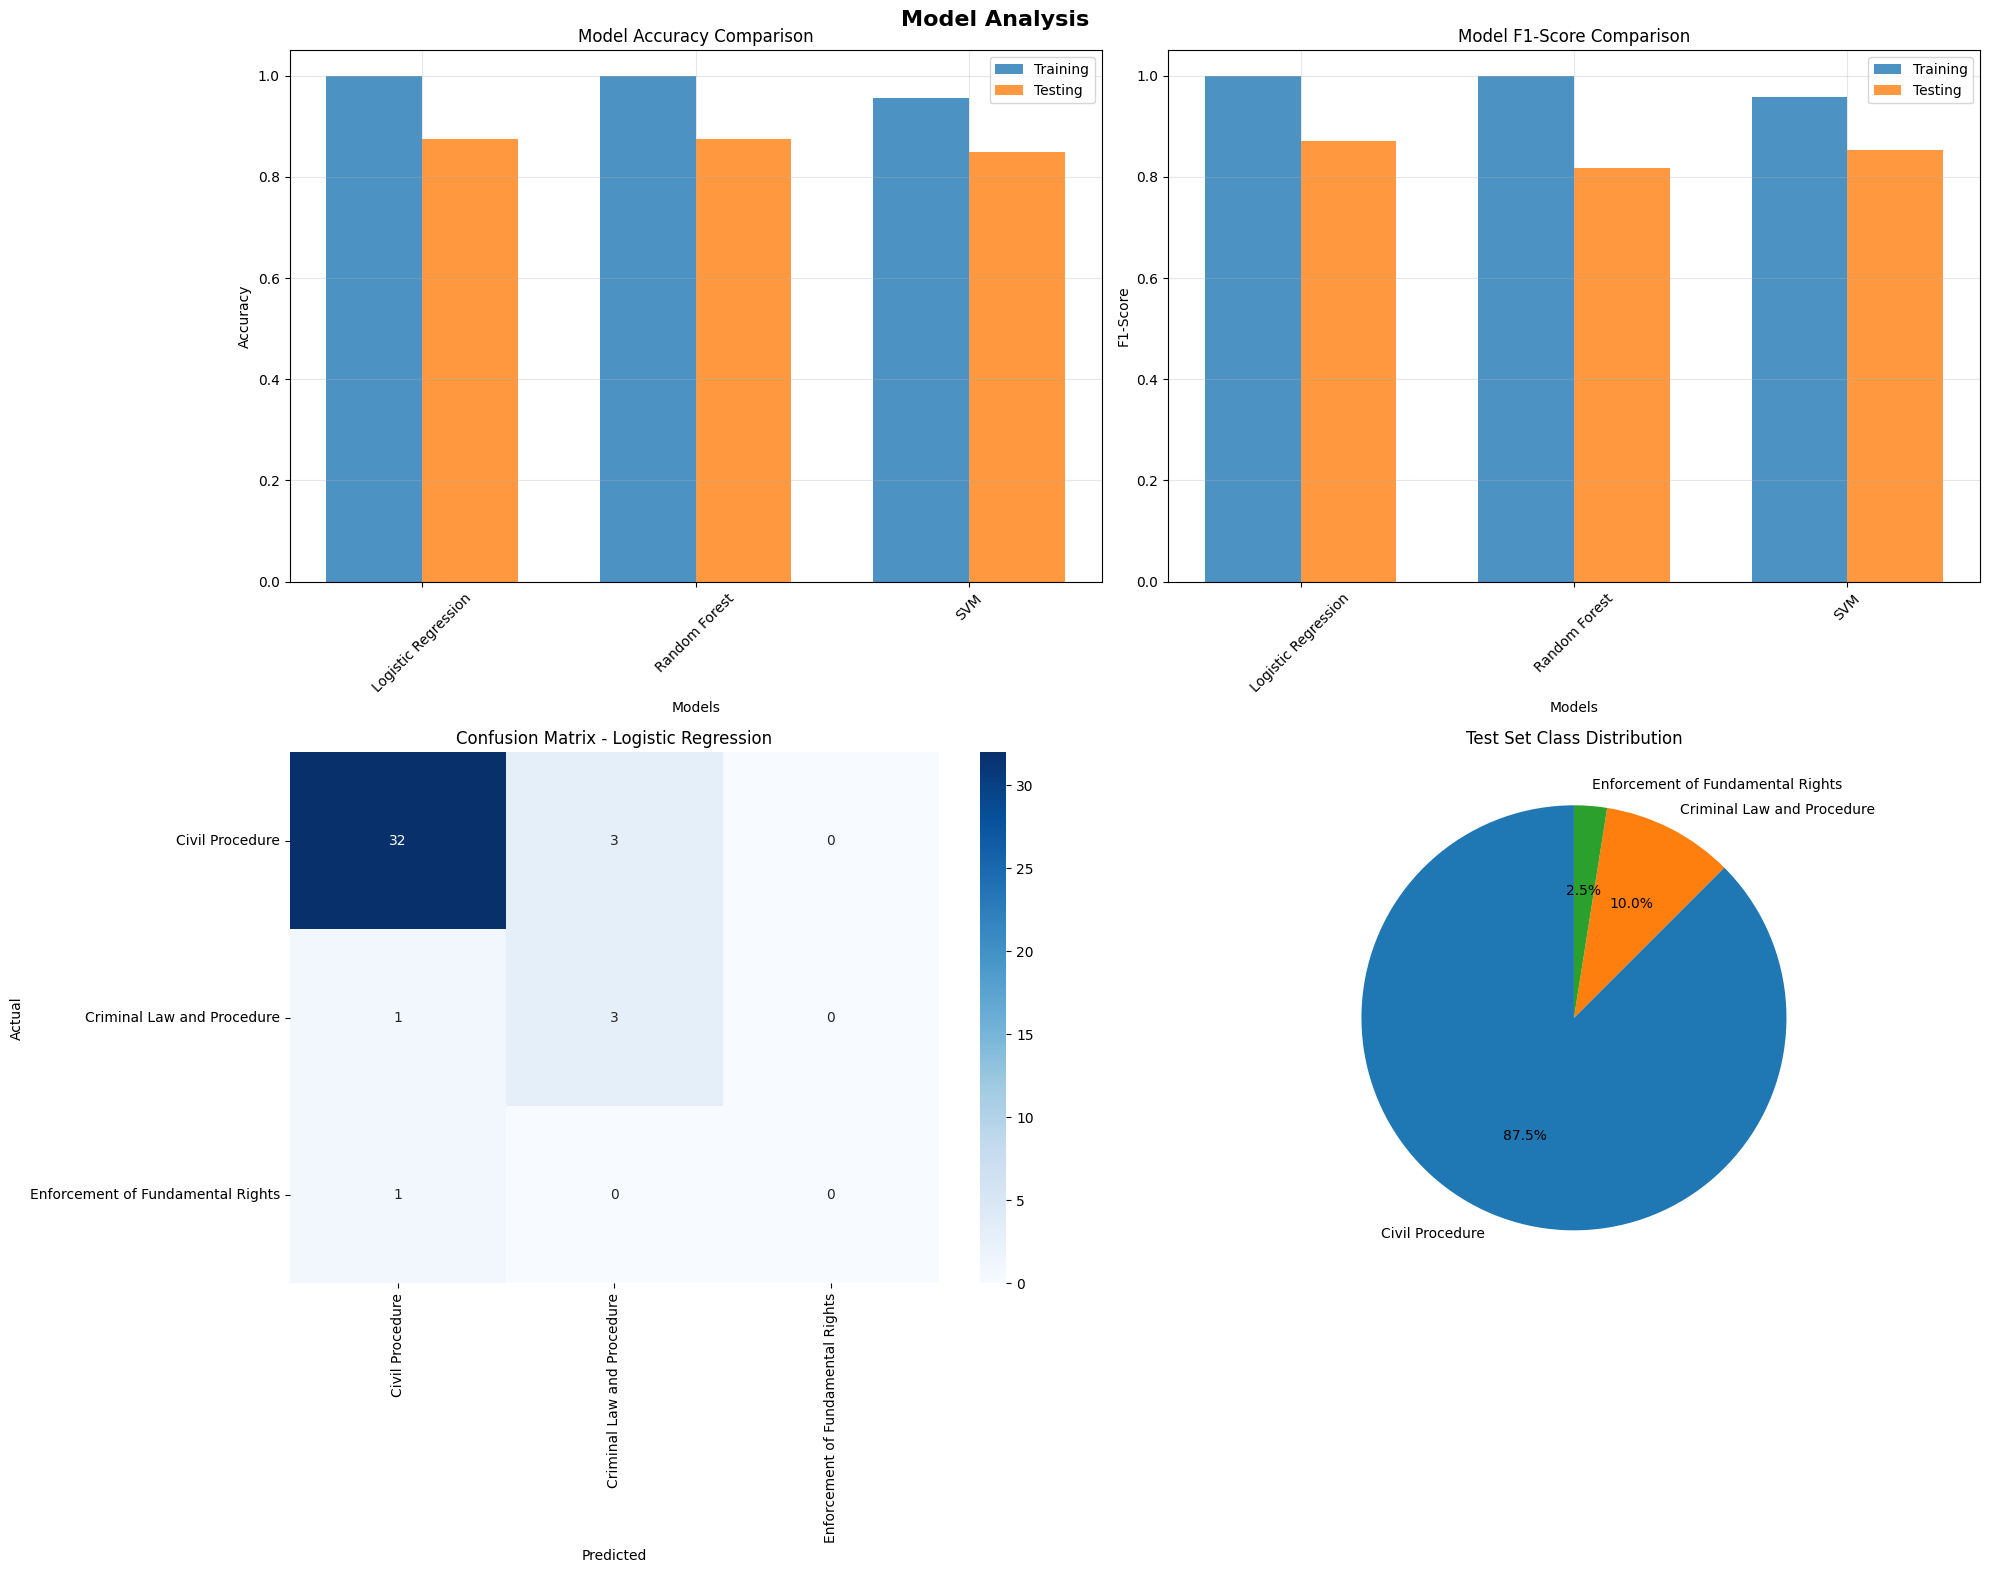


Logistic Regression - Detailed Classification Report:
------------------------------------------------------------
                                   precision    recall  f1-score   support

                  Civil Procedure     0.9412    0.9143    0.9275        35
       Criminal Law and Procedure     0.5000    0.7500    0.6000         4
Enforcement of Fundamental Rights     0.0000    0.0000    0.0000         1

                         accuracy                         0.8750        40
                        macro avg     0.4804    0.5548    0.5092        40
                     weighted avg     0.8735    0.8750    0.8716        40


Random Forest - Detailed Classification Report:
------------------------------------------------------------
                                   precision    recall  f1-score   support

                  Civil Procedure     0.8750    1.0000    0.9333        35
       Criminal Law and Procedure     0.0000    0.0000    0.0000         4
Enforcement of Funda

In [ ]:
# Detailed evaluation of all models
def evaluate_models(results):


        # Create subplots for visualizations of the accuracies
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig.suptitle('Model Analysis', fontsize=16, fontweight='bold')

        # Accuracy Comparison
        model_names = list(results.keys())
        train_accuracies = [results[name]['train_accuracy'] for name in model_names]
        test_accuracies = [results[name]['test_accuracy'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        axes[0,0].bar(x - width/2, train_accuracies, width, label='Training', alpha=0.8)
        axes[0,0].bar(x + width/2, test_accuracies, width, label='Testing', alpha=0.8)
        axes[0,0].set_xlabel('Models')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].set_title('Model Accuracy Comparison')
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels(model_names, rotation=45)
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # F1-Score Comparison
        train_f1s = [results[name]['train_f1'] for name in model_names]
        test_f1s = [results[name]['test_f1'] for name in model_names]

        axes[0,1].bar(x - width/2, train_f1s, width, label='Training', alpha=0.8)
        axes[0,1].bar(x + width/2, test_f1s, width, label='Testing', alpha=0.8)
        axes[0,1].set_xlabel('Models')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].set_title('Model F1-Score Comparison')
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels(model_names, rotation=45)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Confusion Matrix
        best_model_name = max(results.keys(), key=lambda x: results[x]['test_f1'])
        best_result = results[best_model_name]

        cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels= label_encoder.classes_,
                   yticklabels= label_encoder.classes_,
                   ax=axes[1,0])
        axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')

        # Class Distribution
        unique, counts = np.unique(best_result['y_test'], return_counts=True)
        class_names = [label_encoder.classes_[i] for i in unique]

        axes[1,1].pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90)
        axes[1,1].set_title('Test Set Class Distribution')

        plt.tight_layout()
        plt.show()

        # Detailed classification reports
        for name, result in results.items():
            print(f"\n{name} - Detailed Classification Report:")
            print("-" * 60)
            print(classification_report(
                result['y_test'],
                result['y_pred'],
                target_names= label_encoder.classes_,
                digits=4
            ))

evaluate_models(result)

In [ ]:
import pickle
import joblib

# Save the best trained model for deployment
def save_model(filepath: str = 'legal_classifier_model.pkl', best_model=best_model):

        if best_model is None:
            raise ValueError("No model trained yet!")

        model_data = {
            'model': best_model,
            'label_encoder': label_encoder,
            'model_type': type(best_model).__name__
        }

        joblib.dump(model_data, filepath)
        print(f"Model saved successfully to: {filepath}")
        print(f"Model type: {type(best_model).__name__}")
        print(f"Classes: {list(label_encoder.classes_)}")

In [ ]:
save_model()

Model saved successfully to: legal_classifier_model.pkl
Model type: LogisticRegression
Classes: ['Civil Procedure', 'Criminal Law and Procedure', 'Enforcement of Fundamental Rights']


In [ ]:
# Test the trained model with a test data
def prediction(data, model_path: str = 'legal_classifier_model.pkl'):

    # Load model
    model_data = joblib.load(model_path)
    model = model_data['model']
    label_encoder = model_data['label_encoder']

    # Preprocess
    cleaned_text = clean(data)

    # Generate embedding (simplified for testing)

    embedding = get_embeddings([cleaned_text])

    # Predict
    prediction = model.predict(embedding)[0]
    probabilities = model.predict_proba(embedding)[0]

    predicted_class = label_encoder.inverse_transform([prediction])[0]
    confidence = probabilities[prediction]

    print(f"Sample case: {data[:100]}...")
    print(f"Predicted Law Area: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    return predicted_class, confidence

In [ ]:
for i in range(200):
  result = prediction(df["full_report"][i], "/content/legal_classifier_model.pkl")
  print(f"test case {i}")
  print("\n")
  print(result)
  print("\n")

Embeddings shape: (1, 768)
Sample case: GEORGE ADESOLA&nbsp;OGUNTADE, J.C.A. (Delivering the Leading Judgment): The appellant as Plaintiff b...
Predicted Law Area: Civil Procedure
Confidence: 0.9667
test case 1


('Civil Procedure', np.float64(0.9667237543948493))


Embeddings shape: (1, 768)
Sample case: 
CHIOMA EGONDU NWOSU-IHEME&nbsp;J.C.A.  (Delivering the Lead&nbsp;Ruling): Thepresent application fl...
Predicted Law Area: Civil Procedure
Confidence: 0.9932
test case 1


('Civil Procedure', np.float64(0.9932196147189083))


Embeddings shape: (1, 768)
Sample case: PETER OYINKENIMIEMI AFFEN, J.C.A. (Delivering the Leading Judgment): Introduction
This appeal thrust...
Predicted Law Area: Civil Procedure
Confidence: 0.9701
test case 1


('Civil Procedure', np.float64(0.9700996585609197))


Embeddings shape: (1, 768)
Sample case: IBRAHIM SHATA BDLIYA, J.C.A. (Deliveringthe Leading Judgment): This is an appeal againstthe judgment...
Predicted Law Area: Criminal Law and Procedure
Confiden

## Report

Due to the small amount of dataset, there were not enough data to accomodate labels for all areas of law, and the dataset is imbalance as they all till towards the area of Civil Procedure.

Recommendation: With large amount of data, we can build for all labels of law, and properly oversample or undersample to ensure the labels or targets are balance and acheieve better predictions and accuracy.